# Reconnaître des chiffres manuscrits avec du Machine Learning et du Deep Learning

## Installation des paquets nécessaires

In [ ]:
import os

<div class="alert alert-warning">
Le téléchargement de la bibliothèque de deep learning Tensorflow pèse environ 500 Mo, et prend environ 1 Go d'espace disque.
</div>

In [ ]:
os.system("pip install tensorflow scikit-learn")

## Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
from sklearn.model_selection import train_test_split

## Décompression des données 

In [ ]:
with zipfile.ZipFile("digit-recognizer.zip", "r") as zip_obj:
    zip_obj.extract("train.csv")

Si vous êtes sur Windows et que la commande au dessus ne fonctionne pas, vous pouvez aller dézipper manuellement le fichier `digit-recognizer.zip` qui est dans le même dossier que ce notebook.

## Description des données

Le fichier de données train.csv contient des "images"  en noir et blanc de chiffres écrits à la main, de 0 à 9.

Chaque image fait 28 pixels de haut et 28 pixels de large, pour un total de 784 pixels par image.

Chaque pixel est un nombre entre 0 et 255, 0 étant un pixel noir, 255 un pixel blanc, et les nombres entre les deux des nuances de gris.

❓ Pourquoi 255 comme valeur maximale ? C'est le plus grand entier qui tienne en 1 octet : $2^7 + 2^6 + ... + 2^1 + 2^0 = 2^8 - 1 = 255$)

Dans nos données, nous avons techniquement pour chaque ligne / image, 1 colonne `label` qui nous indique de quel chiffre il s'agit, et ensuite 784 colonnes contenant la valeur de chaque pixel. Nos images sont pour l'instant un tableau de nombres aplati en une seule ligne, ce qui signifie que pour les traiter comme des images et les afficher nous devront leur redonner leur forme 28x28.

Nous allons implémenter deux approches différentes pour classifier des images fournies sous cette forme, c'est à dire assigner à chaque image un chiffre entre 0 et 9.

Pour évaluer la performance de ces approches, nous allons utiliser la précision, c'est à dire la proportion d'images correctement classifiées.

Une précision de `0.97` indiquerait que seulement `3%` des images ont été mal classifiées.


## Chargement des données

In [ ]:
X = pd.read_csv("train.csv")

In [ ]:
# y est ce qu’on cherche à prédire, notre "cible", ici à quel chiffre correspond chaque image
y = X.label

In [ ]:
# dans X, notre matrice contenant nos données, on garde tout sauf la colonne qui indique à quel chiffre correspond une image
X = X.drop(columns="label")

## Visualisation
Nous allons visualiser une partie de nos données pour nous faire une idée de leur forme.
Nous allons créer deux petites fonctions.

1. La première prend une position et un objet `matplotlib.Axes` qu'on appelle `ax` et affiche sur cet `ax` l'image située à la position indiquée dans `X`, avec le libellé correspondant pris dans `y`.
2. La seconde crée une grille d'Axes avec le nombre indiqué de lignes et de colonnes, et appelle la première fonction sur chaque `ax` pour y afficher les premiers nombres de notre jeu de données

In [ ]:
def show_image(position, ax):
    """prend une position et un objet matplotlib.Axes
    qu'on appelle ax et affiche sur cet ax l'image située à la position indiquée dans X,
    avec le libellé correspondant pris dans y."""
    # on va chercher une ligne et on la convertit en array
    img = np.array(X.loc[position])
    # on la reshape en 28x28 et on l'affiche sur l'ax avec imshow
    ax.imshow(img.reshape(28, 28), cmap="gray")
    # on va chercher dans y_train à la même position le libellé de l'image (le nombre écrit)
    ax.set_xlabel(y.loc[position])
    # on masque les graduations sur les axes des x et des y
    ax.set_xticks([])
    ax.set_yticks([])

In [ ]:
def show_grid(n_rows, n_cols):
    """crée une grille d'Axes avec le nombre indiqué de lignes et de colonnes,
    et appelle la fonction show_image() sur chaque ax pour y afficher les premiers nombres de notre jeu de données"""
    # on crée une figure et une grille d'ax appelées axs
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 10))
    # on itère sur chaque ax, on y appelle la fonction précédente show_image,
    # enumerate nous donne le numéro de l'ax, axs.flat permet de traverser la grille "à plat"
    for i, ax in enumerate(axs.flat):
        show_image(i, ax)

In [ ]:
show_grid(5, 20)

## Séparation en jeu d'entraînement et jeu de test

Afin de tester plus rigoureusement la performance de nos approches, on doit séparer nos données 2 paquets : 
- une grosse partie pour l'entraînement d’un modèle
- le reste pour mesurer la performance du modèle, sur des données qu’il n’auront pas vues pendant l'entraînement.

Si on ne fait pas cette séparation, on risque de surévaluer la performance de notre modèle, qui pourrait présenter des bons résultats en étant sur-entraîné sur les spécificités de notre jeu de données, sans fonctionner aussi bien sur des données nouvelles.

Nous allons utiliser une répartition 70 | 30, grâce à la fonction `train_test_split()` de scikit-learn que nous avons importée plus haut.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, random_state=1
)

## Première approche simple, par l'array moyen de chaque chiffre

In [ ]:
# on prépare un array avec 1 ligne pour chaque chiffre, et 784 colonnes (nos images font 28*28 pixels)
avg_digits = np.zeros((10, 784))

In [ ]:
# on itère sur chaque nombre entre 0 et 10
for digit in range(10):
    # on calcule la moyenne de chaque ligne / image qui correspond au nombre en cours
    avg_digit = np.mean(X_train[y_train == digit], axis=0)
    # on l'insère dans la matrice qui va contenir la ligne moyenne pour chaque chiffre
    avg_digits[digit] = avg_digit / np.linalg.norm(avg_digit)

In [ ]:
# On trace nos images moyennes de chaque chiffre
fig, axs = plt.subplots(2, 5)
for n, ax in enumerate(axs.flat):
    ax.imshow(avg_digits[n].reshape(28, 28), cmap="gray")

    # on masque les graduations sur les axes des x et des y
    ax.set_xticks([], [])
    ax.set_yticks([], [])

In [ ]:
similarity_matrix = avg_digits @ X_test.to_numpy().T
similarity_matrix

Dans `similarity_matrix`, chaque ligne représente un chiffre entre 0 et 9, et chaque colonne est une image. À l'intersection, on a un nombre indiquant à quel point l'image en colonne correspond au chiffre en ligne. Nos prédictions sont donc pour chaque colonne, le numéro de la ligne avec la plus grande valeur.

In [ ]:
predictions = similarity_matrix.argmax(axis=0)

In [ ]:
predictions

On peut calculer notre précision en comparant notre array de prédictions avec les bonnes valeurs qui sont dans `y_test`.

Pour chaque image où la prédiction est juste, `y_test == predictions` contiendra un `True`, et un `False` quand la prédiction est erronée.

En faisant le calcul de la moyenne de ce résultat avec `np.mean()`, chaque `True` est transformé en `1` et chaque `False` en `0`.

Cela revient à faire le compte des `True` divisé par le nombre total de valeurs.

In [ ]:
accuracy = np.mean(y_test == predictions)
print(f"Précision: {100 * accuracy : .1f}%")

<div class='alert alert-success'>

On obtient une précision supérieure à 80%. 

C'est bien pour une approche aussi simple à implémenter et calculer, mais sans doute insuffisant si votre client est la Poste et que votre but est d’automatiser le tri des enveloppes par code postal automatique.
    
</div>

## Approche par Réseau neuronal convolutif

Un réseau neuronal convolutif (en anglais Convolutional Neural Network ou CNN) est un algorithme d'apprentissage profond utilisé pour analyser des images et réaliser des tâches telles que :
- la classification (est-ce Pierre, Paul ou Jacques sur cette photo ?)
- la détection d'objets (y a-t-il un obstacle sur la route devant moi?)
- la segmentation sémantique (quels sont les différents objets sur la route devant moi)

Un CNN a plusieurs couches de neurones, avec une couche d'entrée adaptée aux données à analyser, une couche de sortie adaptée à la tâche à réaliser, et plusieurs couches intermédiaires dites couches cachées.

Typiquement, dans un CNN, les couches cachées sont des couches convolutives, des couches de *pooling* et des couches *denses*. Des couches de normalisation et de *dropout* sont également utilisées pour limiter la sur-spécialisation sur les données d'entraînement (*overfitting*).

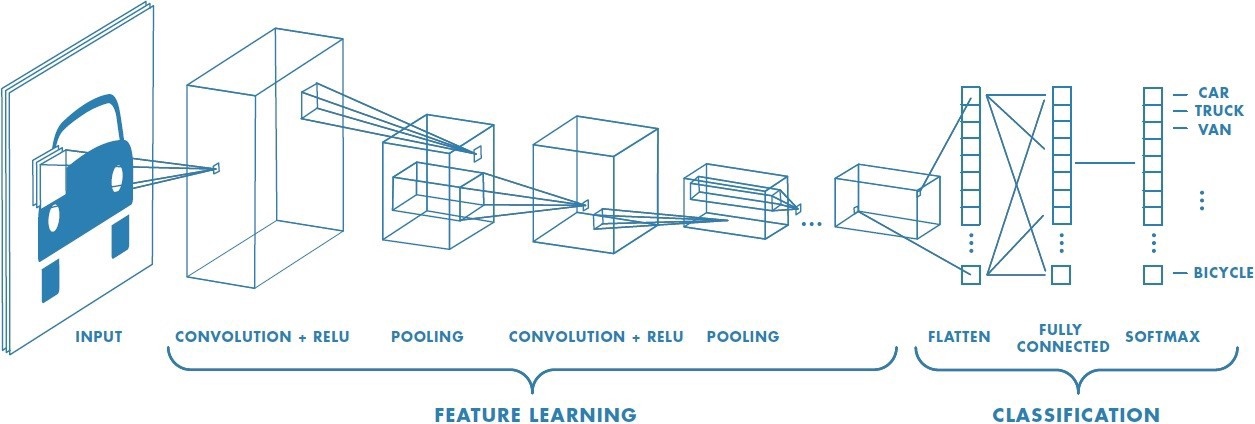

### Les différents types de couches dans un CNN

#### Couches Convolutionnelles

Le rôle de ces couches est de détecter des éléments visuels dans les images comme des bordures, des lignes, des changements de couleur, etc. Ces couches utilisent différents filtres (aussi appelés *kernels*) pour détecter la présence de certaines caractéristiques dans les pixels de l'image.

Un kernel est une matrice de valeurs, appelées poids, qui sont entraînés pour détecter certaines caractéristiques spécifiques. Le kernel réalise son opération sur un groupe de pixels tournant, par simple multiplication élément par élément, puis somme des résulats. L'objectif est d'extraire des caractéristiques de haut niveau, par exemple un trait horizontal, une courbure, un dégradé de couleur…

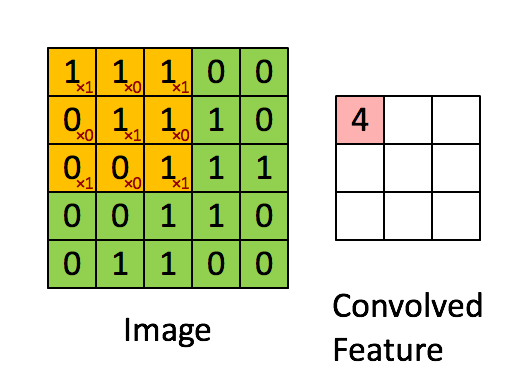

#### Couche de Pooling

Une couche de Pooling réduit les caractéristiques détectées, en prenant les valeurs les plus fortes, ou la moyenne, sur des groupes de valeurs.

Cela permet de réduire le volume des calculs et aussi de limiter la sur-spécialisation sur les images du jeu d'entraînement.

Le *max pooling* a la vertu de réduire le bruit, en ne retenant que les activations les plus fortes faites par le kernel, en ignorant les activations de niveau intermédiaire.


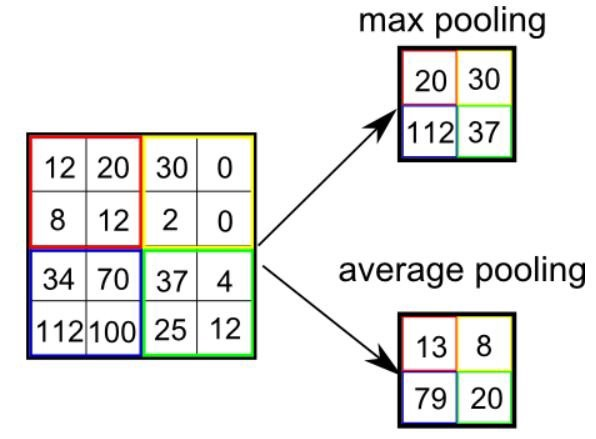

Ces valeurs forment une nouvelle matrice qu'on appelle une *pooled feature map*.


#### Couche d'aplatissement (Flattening)

Après avoir extrait les caractéristiques avec des couches de convolution et de pooling, on va aplatir le résultat et le transmettre à un réseau de neurones classique, à fin de classification.

La couche d'aplatissement convertit la représentation d'image en un long vecteur de caractéristiques.

#### Couches Denses

Le résultat aplati est passé dans un réseau de neurones classiques. La dernière couche dense doit être adaptée à la tâche, avec une fonction d'activation spécialisée pour sortir soit une valeur numérique (prédiction de prix par exemple), soit une classification binaire (l'image représente un chat ou pas) soit une classification multiclasse (à quel chiffre correspond l'image, notre exemple).



#### Dropout

Le dropout est une technique de régularisation qui sert à éviter la sur-spécialisation de notre réseau sur ses données d'entraînement. 

Le principe est d'ignorer au hasard une certaine proportion de nos neurones (typiquement 20%).


### Mise en forme des données
On transforme nos DataFrame de Pandas en array numpy et on donne à chaque image sa forme 28x28 au lieu des 784 nombres à plat

In [ ]:
X_train = X_train.to_numpy().reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.to_numpy().reshape(X_test.shape[0], 28, 28, 1)

In [ ]:
print("training shape", X_train.shape)

### Imports et construction d’un réseau de neurones convolutif avec keras

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
model = Sequential(
    [
        # une couche de neurones convolutifs input shape correspond aux dimensions des images
        Conv2D(64, (3, 3), input_shape=(28, 28, 1), activation="relu", padding="same"),
        # une couche de MaxPool2D
        MaxPool2D(2, 2),
        # une autre couche de neurones convolutifs et son MaxPool
        Conv2D(64, 3, activation="relu", padding="same"),
        MaxPool2D(2, 2),
        # Couche Flatten
        # on met tout à plat à la fin
        Flatten(),
        # Couche dropout
        # on ignore 20% des neurones au hasard. Cela évite à notre réseau d'être
        # trop spécialisé sur son jeu d'entraînement
        Dropout(0.2),
        # la couche finale, avec 10 neurones, correspondant aux 10 valeurs possibles pour une image
        Dense(10, activation="softmax"),
    ]
)

# on affiche le résumé du réseau
model.summary()

### compilation : ajout des paramètres de fonction de perte, d'optimiseur, et le critère d'évaluation (précision)

In [ ]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"],
)

### Entraînement du modèle avec les données dans X_train, y_train. Cela peut prendre plusieurs minutes.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

### Époques
Une époque est un passage sur le jeu de données complet pendant l'entraînement.
On va passer plusieurs fois sur le jeu de données, l'argument `epochs` va déterminer combien de fois au maximum.
S'entraîner pendant trop d'époques pourrait entraîner un sur apprentissage sur nos données d'entraînement, et des performances amoindries sur des données nouvelles. On parle en anglais d’**over-fitting**.

In [ ]:
epochs = 50

### Early stopping

Il faut que le modèle s'entraîne suffisamment pour être performant, mais pas trop au risque de ne pas réussir à généraliser sur des nouvelles données.

La solution à ce problème est l'**early stopping**, c’est à dire mesurer la précision du modèle sur des données de validation, distinctes de celles d'entraînement, et interrompre l'entraînement quand les performances stagnent ou régressent sur le jeu de validation.

In [ ]:
earlystop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

❓ Ici `patience=3` signifie qu'on se laisse 3 époques sans progrès sur la mesure indiquée dans `monitor` avant d'arrêter l'entrainement.

Parfois on ne fait pas de progrès pendant quelques époques puis on se remet à en faire, d’où cet argument `patience`.

`restore_best_weights=True` veut dire qu'on ne s'arrête pas simplement, on s'arrête et on garde les poids (coefficients) des neurones qui avaient les meilleures performances et pas nécessairement ceux au moment où on s'est arrêté.

### Entraînement proprement dit avec la méthode `.fit()`

In [ ]:
history = model.fit(
    X_train,
    y_train,
    batch_size=32,  # le nombre d'images traitées dans une vague
    epochs=epochs, # nombre d'époques au maximum
    validation_data=(
        X_test,
        y_test,
    ),  # le jeu de données sur lesquels les tests de validation sont faits.
    verbose=1, # contrôle la quantité de texte affiché pendant l'entraînement
    callbacks=[earlystop],
)

👍 Maintenant que notre réseau de neurones est enfin entraîné, on va l’utiliser pour prédire les chiffres correspondant aux images dans `X_test`.

In [ ]:
predictions_proba = model.predict(X_test)

In [ ]:
predictions_proba[0]

Dans `predictions_proba`, chaque ligne contient 10 nombres, qui sont les probabilités qu’une image corresponde à chacun des chiffres de 0 à 9.

On va plutôt retenir seulement la position de la probabilité la plus haute de chaque ligne.

In [ ]:
predictions = predictions_proba.argmax(axis=1)
predictions

Pour évaluer la précision, on compare `predictions == y_test`, et comme tout à l’heure, on a un `True` à chaque fois que la prédiction est juste.

On peut donc calculer la moyenne de cet array de `True` et `False`, et obtenir notre précision.

In [ ]:
accuracy = np.mean(predictions == y_test)
accuracy

Un moyen plus simple est d'utiliser la méthode `.evaluate()` sur le modèle.

In [ ]:
model.evaluate(X_test, y_test)

<div class='alert alert-success'>

Notre modèle par réseau de neurone convolutif arrive à une précision proche de 99%, et pourrait faire mieux avec un entraînement plus long, ou un jeu de données plus riche.

</div>

<div class='alert alert-info'>

Si vous avez la moindre question sur cet exemple, n'hésitez pas à me solliciter philippe.lemaire@insa-lyon.fr

</div>